# Lab-09: DBpedia14 classification with BERT

In Lab-03 we used linear text classification models (the perceptron, linear SVM, multinomial naive Bayes, softmax regression) on the DBpedia14 dataset. Recall that our best test accuracy was in the 92-93% range. Here we will use the BERT transformer model pretrained on vast amounts of text data to achieve ~99% test accuracy with minimal hyperparameter tuning.

### Class labels

In [15]:
labels = {
    0: "Company",
    1: "EducationalInstitution",
    2: "Artist",
    3: "Athlete",
    4: "OfficeHolder",
    5: "MeanOfTransportation",
    6: "Building",
    7: "NaturalPlace",
    8: "Village",
    9: "Animal",
    10: "Plant",
    11: "Album",
    12: "Film",
    13: "WrittenWork"
}

K = len(labels)

## Download the dataset

In [16]:
# Colab provides limited GPU time (be mindful when increasing this number)
M = 30000

In [5]:
pip install datasets


     |████████████████████████████████| 298 kB 11.0 MB/s 
     |████████████████████████████████| 61 kB 480 kB/s 
     |████████████████████████████████| 1.1 MB 36.7 MB/s 
     |████████████████████████████████| 243 kB 54.1 MB/s 
     |████████████████████████████████| 132 kB 52.2 MB/s 
     |████████████████████████████████| 271 kB 53.5 MB/s 
     |████████████████████████████████| 192 kB 50.8 MB/s 
     |████████████████████████████████| 160 kB 44.9 MB/s 


In [6]:
import datasets
import pandas as pd

In [2]:


df_train, df_test = datasets.load_dataset(
    'dbpedia_14', 
    split=['train[:80%]', 
           'test[80%:]']
)

df_train = df_train.to_pandas().sample(frac=1).reset_index(drop=True)[:int(0.8 * M)]
df_test = df_test.to_pandas().sample(frac=1).reset_index(drop=True)[:int(0.2 * M)]

ModuleNotFoundError: ignored

## (5 pts) Task 1: Analyze the data

a. What is the distribution of the labels in this data? *Hint*: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html

b. Compute the distribution of sentence length in the dataset

c. Are there any differences between the train and test sets? If so make any necessary changes to the train/test sets such that they look the same.

In [ ]:
df_train.head()

label                           title  \
0      9                   Odontopodisma   
1      5  South African Class 25NC 4-8-4   
2      6               Breed Street Shul   
3      3                   Nelson Graves   
4      6               George IV Brixton   

                                             content  
0   Odontopodisma is a genus of insect in family ...  
1   The South African Class 25NC 4-8-4 of 1953 is...  
2   Breed Street Shul also known as Congregation ...  
3   Nelson Zwinglius Graves (10 August 1880 – 31 ...  
4   George IV Brixton was a public house and conc...

array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

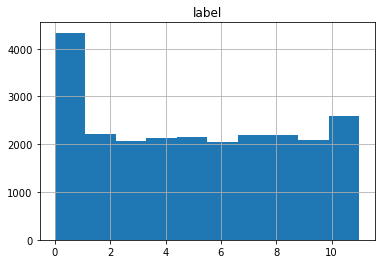

In [ ]:
df_train.hist() # distribution of labels as we see label 1 is the largest

array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

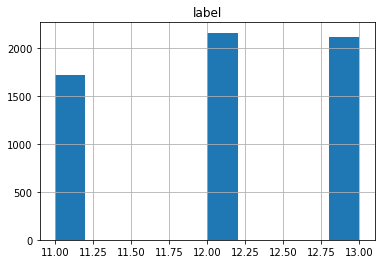

In [ ]:
df_test.hist() # here we see the distribution of labels in the test set only aare 11, 12, and 13

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

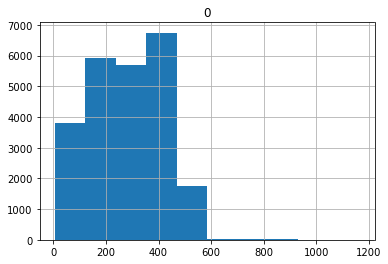

In [ ]:
sent_length_train = []
for i in range(0,len(df_train)):
    sent_length_train.append(len(df_train.content[i]))

train_content = pd.DataFrame(sent_length_train)
train_content.hist()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

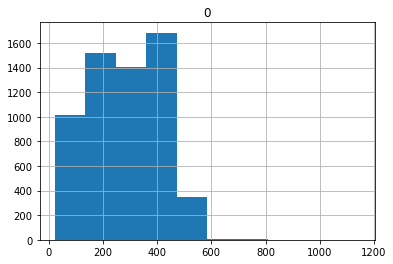

In [ ]:
sent_length_test = []
for i in range(0,len(df_test)):
    sent_length_test.append(len(df_test.content[i]))

test_content = pd.DataFrame(sent_length_test)
test_content.hist()

In [ ]:
df_test.label

0       12
1       11
2       12
3       13
4       13
        ..
5995    12
5996    11
5997    11
5998    13
5999    13
Name: label, Length: 6000, dtype: int64

The only differences between the train and test data is that there is not an distributed amount of labels. The training set only has 1-10 and the test set has 11-13. This will not work because the labels in the training set will never be able to predict what is in the test set so this needs to be fixed. 

In [17]:
df_train, df_test = datasets.load_dataset(
    'dbpedia_14', 
    split=['train[:80%]', 
           'test[20%:]']
)

df_train = df_train.to_pandas().sample(frac=1).reset_index(drop=True)[:int(0.5 * M)]
df_test = df_test.to_pandas().sample(frac=1).reset_index(drop=True)[:int(0.5 * M)]

Reusing dataset d_bpedia14 (/root/.cache/huggingface/datasets/d_bpedia14/dbpedia_14/2.0.0/7f0577ea0f4397b6b89bfe5c5f2c6b1b420990a1fc5e8538c7ab4ec40e46fa3e)


  0%|          | 0/2 [00:00<?, ?it/s]

array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

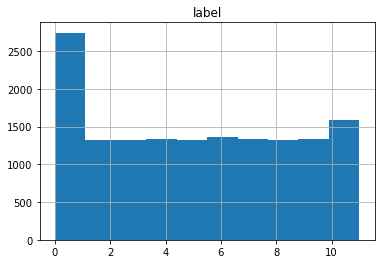

In [ ]:
df_train_new.hist()

array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

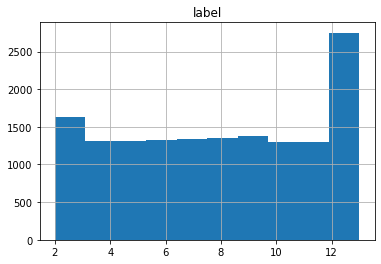

In [ ]:
df_test_new.hist()

## (10 pts) Task 2: Train BERT on DBpedia14 using the provided code

Here you just need to run the cells below on a GPU. To do this we are going to use Google CoLab, which provides free (but limited) use of hosted GPU instances.

Before doing this, take a look at the leaderboard for DBpedia14: https://paperswithcode.com/dataset/dbpedia. You'll find various transformers (including BERT) at the top. Here we will use a smaller version of BERT called DistilBERT which reduces the computational overhead with only marginal performance degradation, and only two training epochs over an abridged version of the dataset.

How does DistilBERT perform relative to the linear text classifiers from Lab 03?

### Google CoLab

To complete tasks 2 & 3, you will need to login to a Google account and then go here: https://colab.research.google.com. Then do the following:

1. End any existing CoLab sessions that you have running

2. Click on the `Upload` tab and upload this file

3. Click on `Runtime -> Change runtime type` and select `GPU`

### Install packages

In [10]:
!pip install -q transformers torch

     |████████████████████████████████| 3.1 MB 12.5 MB/s 
     |████████████████████████████████| 895 kB 31.6 MB/s 
     |████████████████████████████████| 596 kB 54.6 MB/s 
     |████████████████████████████████| 3.3 MB 54.3 MB/s 


### Restart runtime

After running the cell above, click `Runtime -> Restart runtime`. This only needs to be done one time per session.

### Hyperparameters

In [11]:
batch_size = 32
epochs = 2
lr_init = 1e-5
max_len = 256
warmup_steps = 3

### Create batched inputs using Huggingface's DistilBERT tokenizer 

In [18]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

def batch_data(data, bsize):
    batches = []
    sentences = data['content'].tolist()
    labels = data['label'].tolist()
    for i in range(0, len(sentences), bsize):
        s = sentences[i: i + bsize]
        Y = labels[i: i + bsize]
        X = tokenizer.batch_encode_plus(
            s, max_length=max_len, padding='longest', truncation=True,
            return_attention_mask=True, return_token_type_ids=False)
        batches.append((X, Y, s))
    return batches

train_batches = batch_data(df_train, bsize=batch_size)
test_batches = batch_data(df_test, bsize=batch_size)

### Load pretrained Distilbert model

This cell uses the `DistilBertForSequenceClassification` class, which is a convenience wrapper that places a classification head onto the DistilBert language model. 

In [20]:
from tqdm import tqdm
import torch
from transformers import DistilBertForSequenceClassification, \
  AdamW, get_linear_schedule_with_warmup


model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased', 
    num_labels=K, 
    output_hidden_states=True)

if torch.cuda.is_available():
    device = torch.device('cuda:0') # GPU
else:
    device = torch.device('cpu') # CPU
model.to(device)

optimizer = AdamW(model.parameters(), lr=lr_init)
lr = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, 
    num_training_steps=len(train_batches))

Downloading:   0%|          | 0.00/251M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier

### Training loop

*Note: This should take about 20 minutes on CoLabs K80 GPUs*

In [7]:
from datasets import load_metric

def runner(batches, desc: str, train=True):
    
    grad_mode = torch.enable_grad if train else torch.no_grad
    preds = []
    
    if train:
        model.train()
    else:
        model.eval()
    
    for epoch in range(epochs if train else 1):
        
        acc = load_metric("accuracy", keep_in_memory=True)
        f1 = load_metric("f1", keep_in_memory=True)
        cumloss = 0.0
        embeds = []
        
        with tqdm(total=len(batches)) as bar:

            for i, batch in enumerate(batches):
                X, Y, _ = batch
                inputs = torch.tensor(X['input_ids'], device=device)
                attmsk = torch.tensor(X['attention_mask'], device=device)
                labels = torch.tensor(Y, device=device)
                batch = {'input_ids': inputs,
                         'attention_mask': attmsk,
                         'labels': labels}
                with grad_mode():
                    outputs = model(**batch)
                    embeds.append(outputs[-1][1][:, 0, :].squeeze().detach().cpu())
                    loss = outputs.loss
                    if train:
                        loss.backward()
                        optimizer.step()
                        lr.step()
                        optimizer.zero_grad()
                    logits = outputs.logits
                    Yhat = torch.argmax(logits, dim=-1)
                    preds.append(Yhat)
                    cumloss += loss.clone().detach().cpu().item()
                    acc.add_batch(predictions=Yhat, references=Y)
                    f1.add_batch(predictions=Yhat, references=Y)

                bar.update(1)
            bar.set_description('epoch: %s, %s loss: %.5f, f1-score: %.5f, accuracy: %.5f' %
                                (epoch + 1, desc,
                                 cumloss / (i + 1),
                                 f1.compute(average="macro")['f1'],
                                 acc.compute()['accuracy']))
                
    embeds = torch.cat(embeds, dim=0)
        
    return preds, embeds

In [12]:
# Train model
runner(train_batches, 'train');

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

epoch: 1, train loss: 0.64295, f1-score: 0.82749, accuracy: 0.90373: 100%|██████████| 469/469 [05:07<00:00,  1.52it/s]
epoch: 2, train loss: 0.15944, f1-score: 0.98904, accuracy: 0.98840: 100%|██████████| 469/469 [05:07<00:00,  1.52it/s]


### Model evaluation

In [21]:
# Evaluate training set
runner(train_batches, 'train', train=False);

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

epoch: 1, train loss: 2.63468, f1-score: 0.03346, accuracy: 0.09767: 100%|██████████| 469/469 [01:49<00:00,  4.29it/s]


In [22]:
# Evaluate test set
runner(test_batches, 'test', train=False);

epoch: 1, test loss: 2.64885, f1-score: 0.02200, accuracy: 0.01960: 100%|██████████| 469/469 [01:50<00:00,  4.25it/s]


## (5 pts) Task 3: test your model on new string

Make up (or find) a document that maps to one of the 14 classes in DBpedia14. Is the model's prediction in agreement with your label assignment? The cell below contains some helper code to get you started. To compute the model prediction, reuse the `batch_data()` and `runner()` functions.

### Starter code

In [23]:
import numpy as np
import pandas as pd

example_text = """Her is a 2013 American science-fiction romantic drama film written, 
directed, and produced by Spike Jonze. It marks Jonze's solo screenwriting debut. 
The film follows Theodore Twombly (Joaquin Phoenix), a man who develops a relationship 
with Samantha (Scarlett Johansson), an artificially intelligent virtual assistant 
personified through a female voice."""

example_label = 12 # "film"

df = pd.DataFrame({'content': [example_text], 'label': example_label, 'title': None})

In [24]:
df

content  label title
0  Her is a 2013 American science-fiction romanti...     12  None

In [27]:
K = 1
train_batches2 = batch_data(df_train, bsize=batch_size)
test_batches2 = batch_data(df_test, bsize=batch_size)

In [28]:
# Train model
runner(train_batches2, 'train');

epoch: 1, train loss: 0.67108, f1-score: 0.81958, accuracy: 0.89147: 100%|██████████| 469/469 [04:58<00:00,  1.57it/s]
epoch: 2, train loss: 0.15838, f1-score: 0.99023, accuracy: 0.98980: 100%|██████████| 469/469 [04:59<00:00,  1.57it/s]


In [30]:
runner(train_batches2, 'train', train=False);

epoch: 1, train loss: 0.12980, f1-score: 0.99048, accuracy: 0.99007: 100%|██████████| 469/469 [01:49<00:00,  4.28it/s]


In [31]:
runner(test_batches2, 'test', train=False);

epoch: 1, test loss: 0.86192, f1-score: 0.64343, accuracy: 0.81133: 100%|██████████| 469/469 [01:49<00:00,  4.27it/s]


## (5 pts extra credit) Task 4: Extract the document embeddings and visualize them in Tensorboard Projector

### TSV helper functions from Lecture 05

In [ ]:
def save_matrix(matrix, fpath):
    D1, D2 = matrix.shape
    tsv = ""
    for i in range(D1):
        for j in range(D2):
            tsv += str(matrix[i, j]) + '\t'
        tsv = tsv.strip('\t') + '\n'
    tsv = tsv.strip('\n')
    with open(fpath, "w") as fd:
        fd.write(tsv)

def save_docs(docs, labels, fpath):
    tsv = "document\tlabel\n"
    for doc, label in zip(docs, labels):
        tsv += doc.lower().strip() + '\t' + label + '\n'
    tsv = tsv.strip('\n')
    with open(fpath, "w") as fd:
        fd.write(tsv)

### Extract embeddings

In [ ]:
# Your code goes here

### Visualize embeddings

The embeddings and text can be saved in tsv format and uploaded here  https://projector.tensorflow.org/ for visualization. Choose the tSNE algorithm.

In [ ]:
# Your code goes here